In [1]:
using Dates
using PyPlot
using DelimitedFiles
using Statistics
using LinearAlgebra
using Statistics
const plt = PyPlot

PyPlot

In [2]:
using Pkg
Pkg.develop(path="/home/ctroupin/ULiege/Tools/DIVAnd.jl")

# check with:
Pkg.status()

using DIVAnd
@show pathof(DIVAnd)

      Status `~/.julia/environments/v1.7/Project.toml`
  [336ed68f] CSV v0.9.11
  [8be319e6] Chain v0.4.8
  [8f4d0f93] Conda v1.7.0
  [efc8151c] DIVAnd v2.7.7 `~/ULiege/Tools/DIVAnd.jl`
  [1b7aed40] DIVAndNN v0.1.0 `https://github.com/gher-ulg/DIVAndNN.jl#master`
  [7f46824f] DIVAnd_HFRadar v0.1.0 `https://github.com/gher-ulg/DIVAnd_HFRadar.jl#master`
  [864edb3b] DataStructures v0.18.10
  [b4f34e82] Distances v0.10.6
  [31c24e10] Distributions v0.25.29
  [2fb1d81b] GeoArrays v0.6.0
  [855c05df] GeoMapping v0.0.0 `git@github.com:Alexander-Barth/GeoMapping.jl.git#master`
  [0ef565a4] Geodesy v1.0.1
  [c27321d9] Glob v1.3.0
  [cd3eb016] HTTP v0.9.17
  [7073ff75] IJulia v1.23.2
  [a98d9a8b] Interpolations v0.13.4
  [682c06a0] JSON v0.21.2
  [23992714] MAT v0.10.1
  [e1d29d7a] Missings v1.0.2
  [0db19996] NBInclude v2.3.0
  [85f8d34a] NCDatasets v0.11.7
  [b946abbf] NaNStatistics v0.5.5
  [626c502c] Parquet v0.8.3
  [3725be50] PhysOcean v0.6.5
  [f3e62ec7] PkgCleanup v0.1.0 `https://github

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


"/home/ctroupin/ULiege/Tools/DIVAnd.jl/src/DIVAnd.jl"

## Files and directories
We need to have:
1. the temperature data
2. the CPR observations
3. the bathymetry.

In [3]:
datadir = "../data/"
datadir2 = "../data/WOD/"
figdir = "../figures/multivariateL1/"
resdir = "../results/multivariateL1/"
isdir(resdir) ? @debug("already there") : mkpath(resdir)
isdir(figdir) ? @debug("already there") : mkpath(figdir)

The file `temperature_surface_WOD2.nc` contains all the temperature measurements in the region of interest and for a depth between 5 m and the sea surface.       
It was prepared with the notebook [`read_plot_WOD_data`](read_plot_WOD_data.ipynb).

In [4]:
datafile = joinpath(datadir, "MBA_CPRdata_Emodnet_21Jan22.csv")
isfile(datafile) ? @debug("already downloaded") : download("https://dox.ulg.ac.be/index.php/s/hjWKf1F3C1Pzz1r/download", datafile)
bathfile = joinpath(datadir, "gebco_30sec_16.nc")
isfile(bathfile) ? @debug("already downloaded") : download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download", bathfile)
temperaturefile = joinpath(datadir2, "temperature_surface_WOD2.nc")
isfile(temperaturefile) ? @info("Temperature file already prepared") : download("https://dox.ulg.ac.be/index.php/s/aksXIhEFk41npCb/download", temperaturefile);

┌ Info: Temperature file already prepared
└ @ Main In[4]:6


## Domain, metrics, mask

In [5]:
dom = [-20.5, 11.75, 41.25, 67.]

4-element Vector{Float64}:
 -20.5
  11.75
  41.25
  67.0

In [6]:
Δlon = 0.5
Δlat = 0.5
longrid = dom[1]:Δlon:dom[2]
latgrid = dom[3]:Δlat:dom[4]
@info("Size of the grid: $(length(longrid)) X $(length(latgrid))")

_, (pm, pn), (xi, yi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid);
@info(size(xi));

┌ Info: Size of the grid: 65 X 52
└ @ Main In[6]:5
┌ Info: (65, 52)
└ @ Main In[6]:8


### Mask

In [7]:
_, _, mask = DIVAnd.load_mask(bathfile, true, longrid, latgrid, 0.0);

# - Resolution = 0.5°
maskindex = findall((xi .>= 0.) .& (yi .<= 47.))
mask[maskindex] .= 0.;

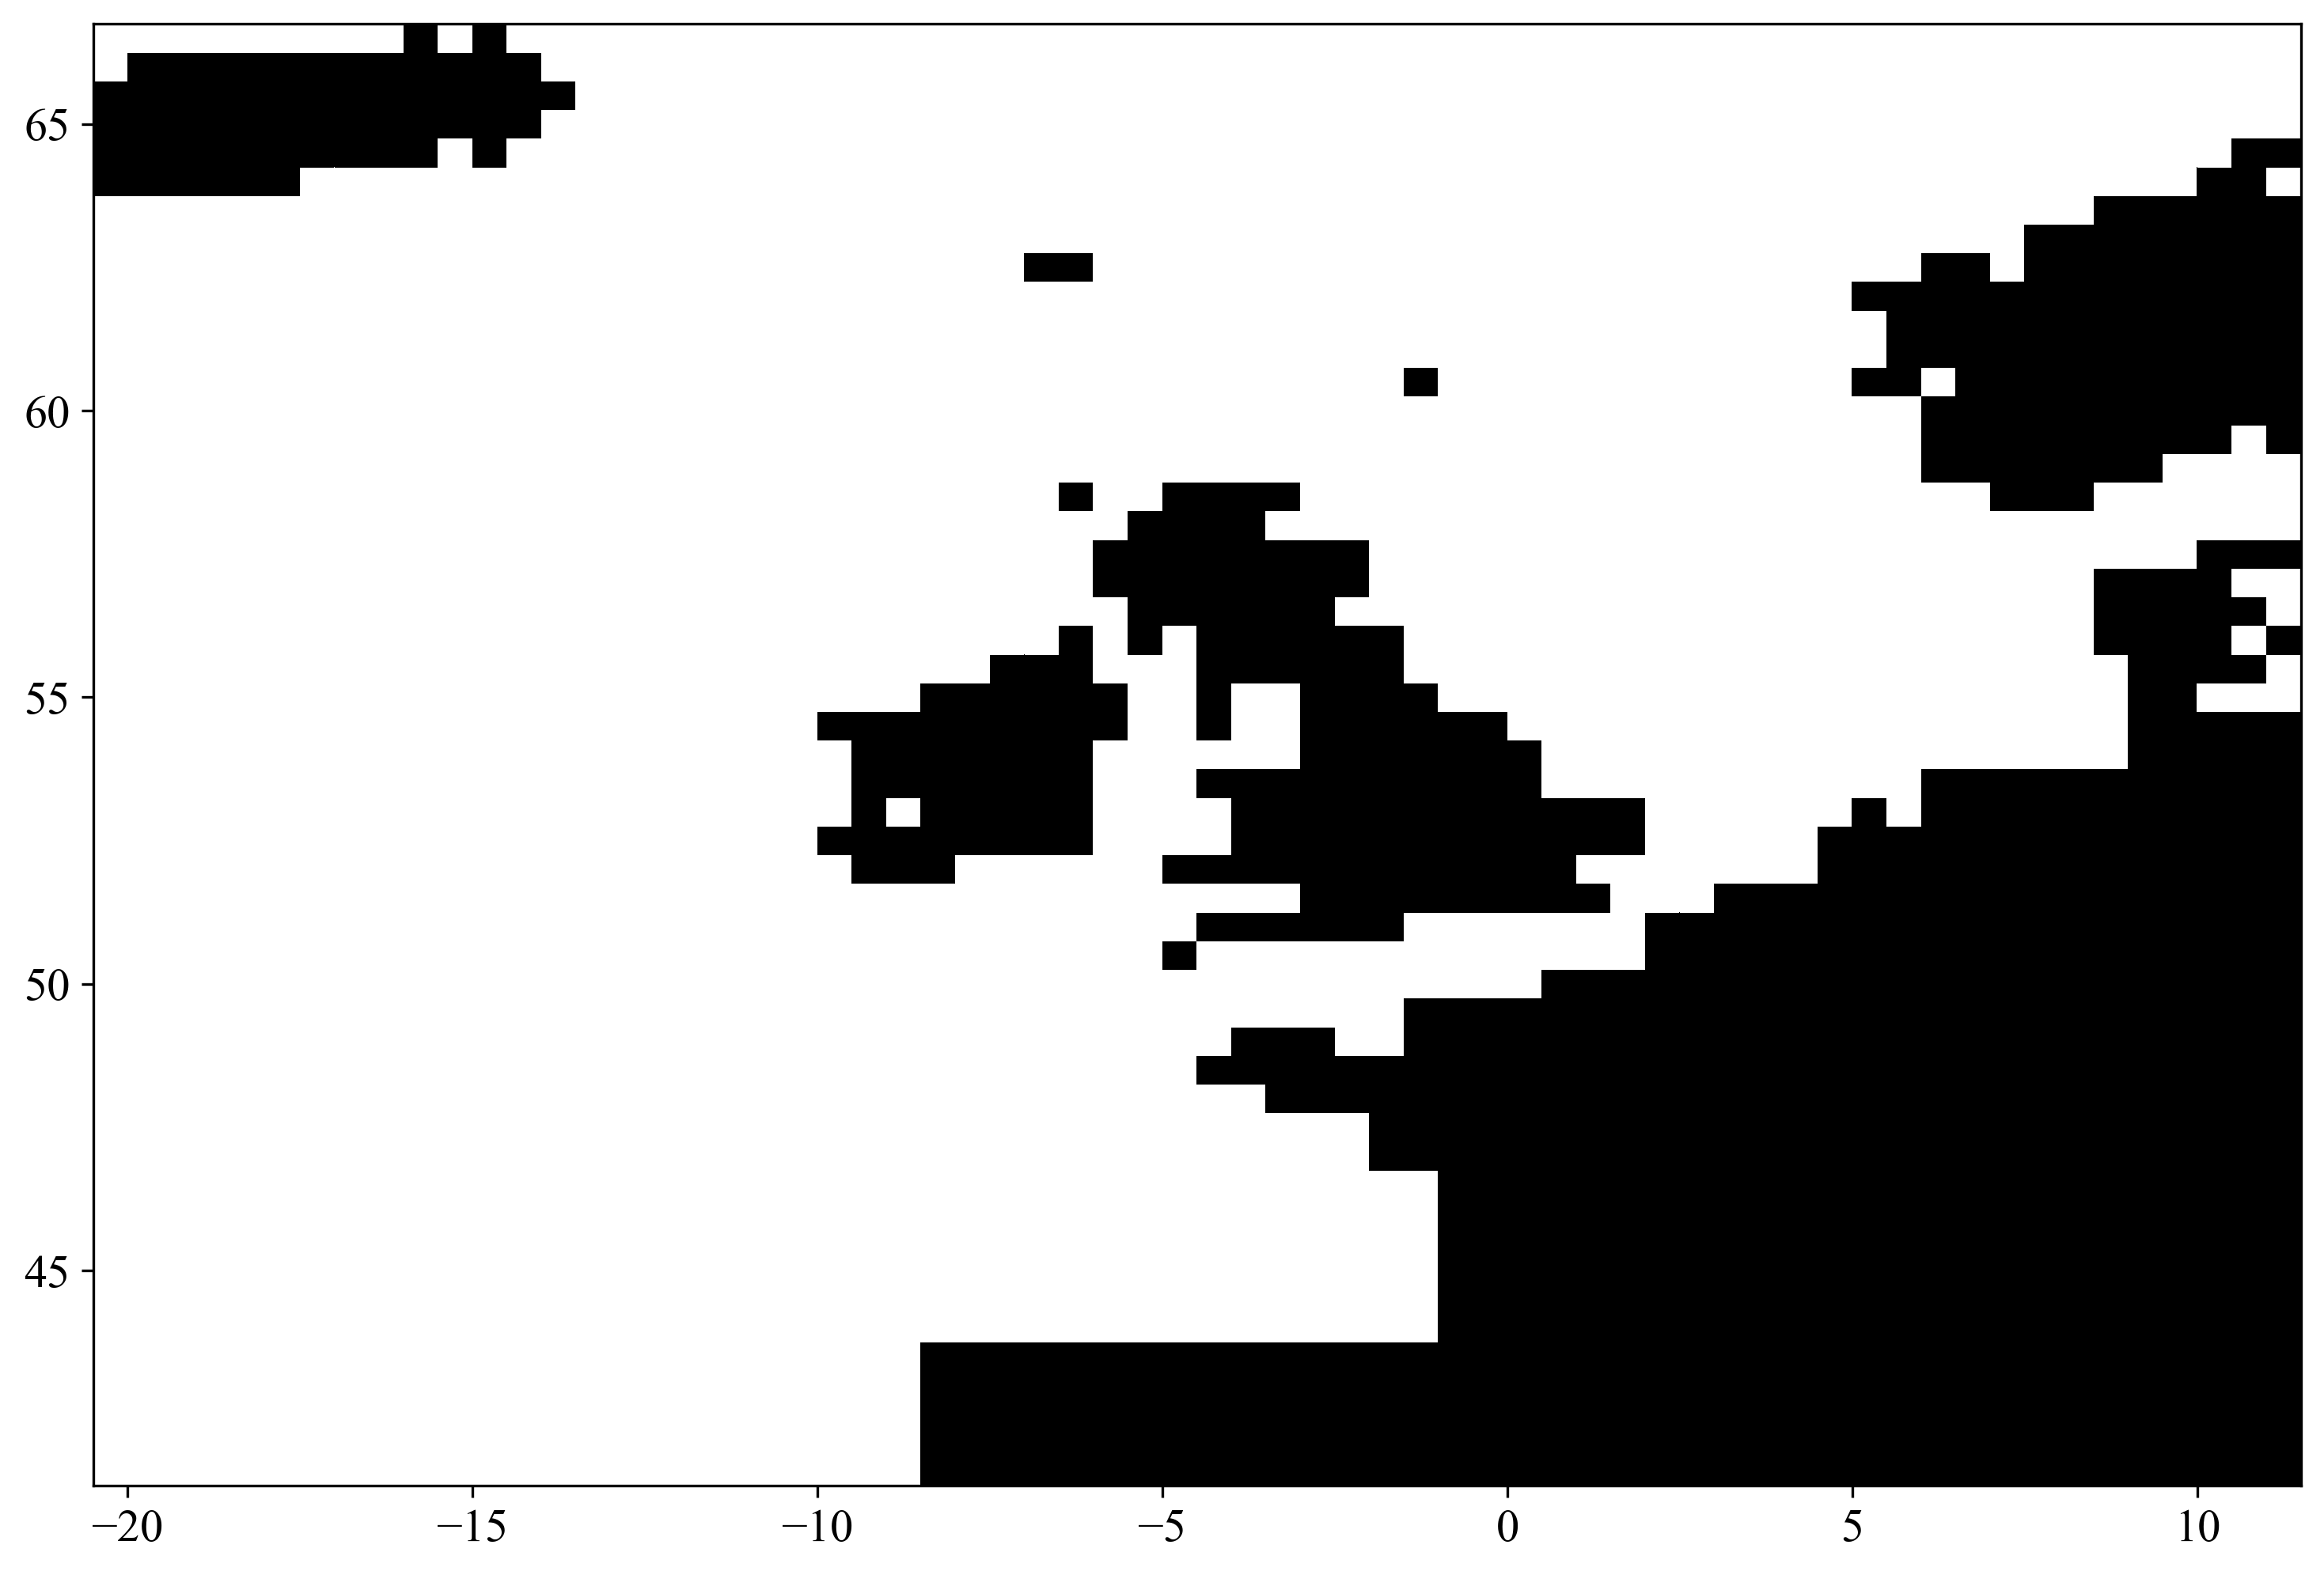

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/ctroupin/.julia/packages/PyCall/3fwVL/src/numpy.jl:67


In [8]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r)
plt.show()

## Read the data
We will prepare monthly fields for given time periods.

In [9]:
yearmin = 1995
yearmax = 2000
imonth = 1

1

### Temperature

In [10]:
@time obsvalue, obslon, obslat, obsdepth, obstime, obsids = loadobs(Float64, temperaturefile, "Temperature");
year_temperature = Dates.year.(obstime);
month_temperature = Dates.month.(obstime);
goodyear = (year_temperature .>= yearmin ) .& (year_temperature .<= yearmax) .& (month_temperature .== 1)
@info("Found $(sum(goodyear)) observations for the period $(Dates.monthname(imonth)) $(yearmin) - $(yearmax)");

  1.652234 seconds (4.18 M allocations: 282.981 MiB, 4.20% gc time, 89.21% compilation time)


┌ Info: Found 5246 observations for the period January 1995 - 2000
└ @ Main In[10]:5


In [11]:
@time lonT, latT, depthT, timeT, dataT = obslon[goodyear], obslat[goodyear], obsdepth[goodyear], 
obstime[goodyear], obsvalue[goodyear];

  0.119663 seconds (123.09 k allocations: 6.504 MiB, 14.06% gc time, 99.87% compilation time)


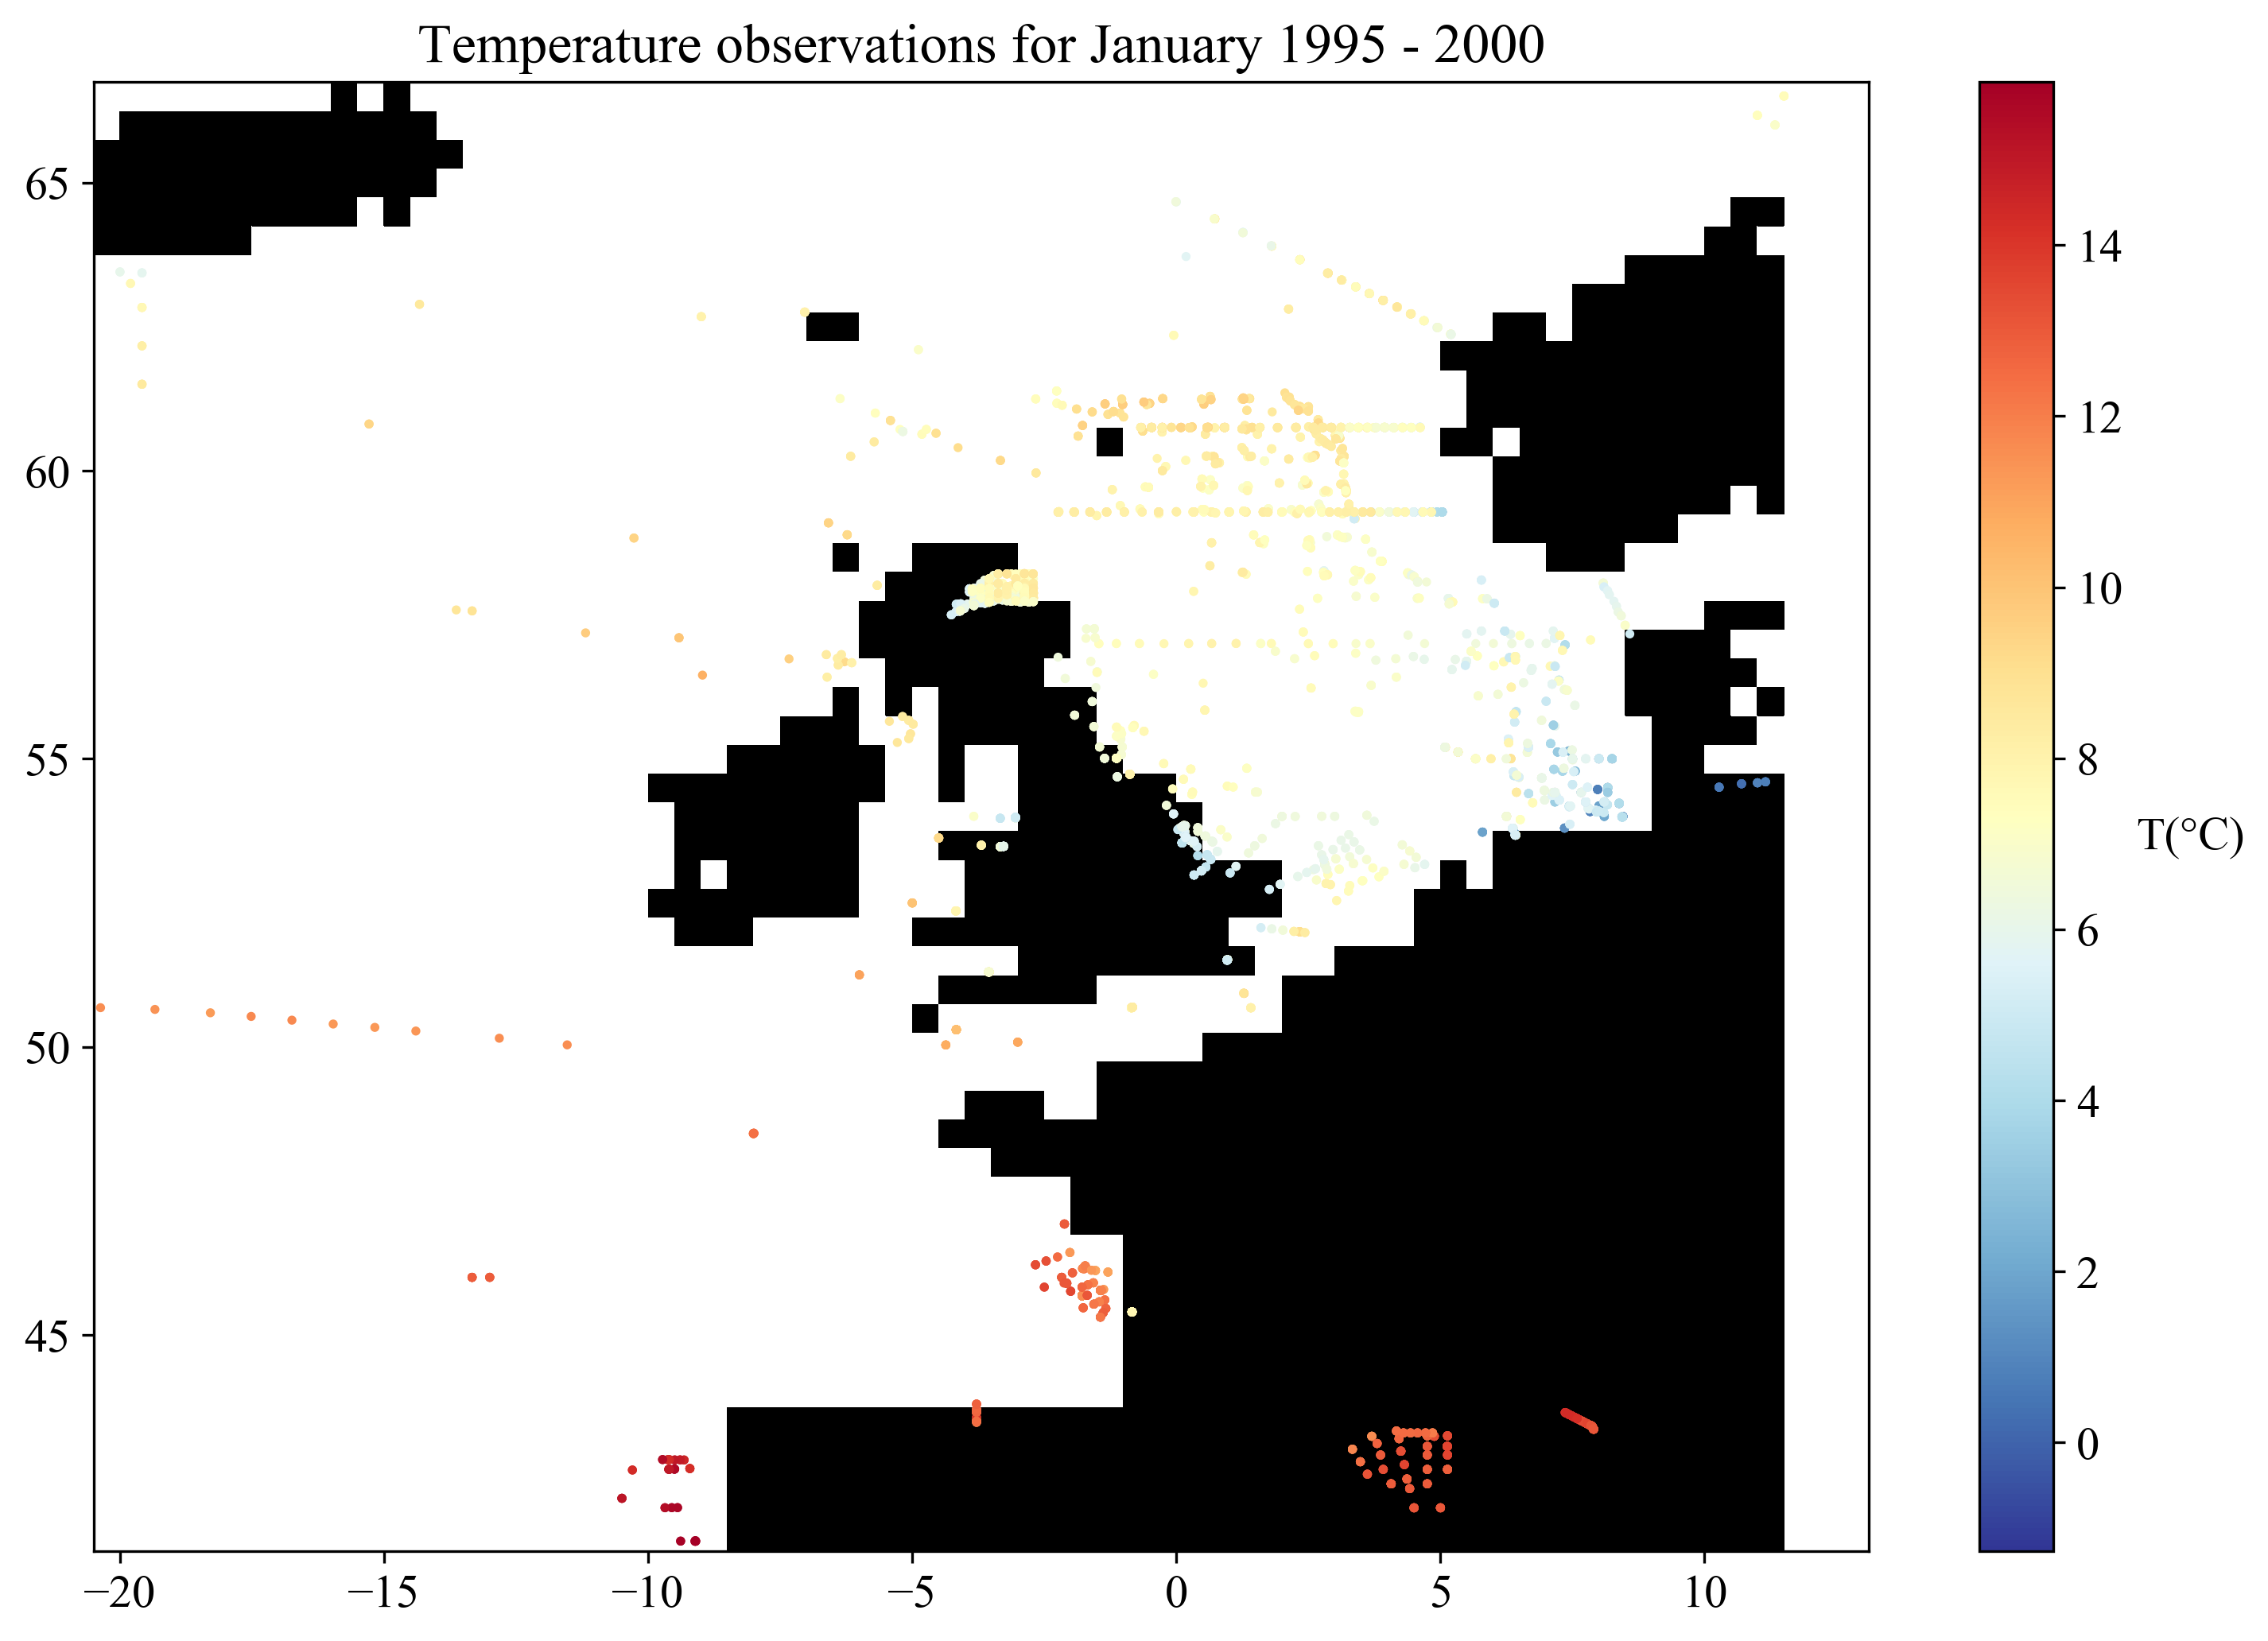

In [12]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
pcm = ax.scatter(lonT, latT, s=3, c=dataT, cmap=plt.cm.RdYlBu_r, zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
cb = plt.colorbar(pcm)
cb.set_label("T(°C)", rotation=0, ha="left")
ax.set_title("Temperature observations for $(Dates.monthname(imonth)) $(yearmin) - $(yearmax)")
plt.show()

### Plankton

In [13]:
data = DelimitedFiles.readdlm(datafile, ',', skipstart=1);
lonCPR = Float64.(data[:,3])
latCPR = Float64.(data[:,2])
yearCPR = data[:,4]
monthCPR = data[:,5]
timeCPR = Dates.Date.(yearCPR, monthCPR, 15)
calanus_finmarchicus = Float64.(data[:,6])
calanus_helgolandicus = Float64.(data[:,7]);

#### Subsetting

In [14]:
goodyearCPR = (yearCPR .>= yearmin ) .& (yearCPR .<= yearmax) .& (monthCPR .== imonth)
@info("Found plankton $(sum(goodyearCPR)) observations for the period $(Dates.monthname(imonth)) $(yearmin) - $(yearmax)");

┌ Info: Found plankton 1055 observations for the period January 1995 - 2000
└ @ Main In[14]:2


In [15]:
@time lon_calanus, lat_calanus, time_calanus, 
calanus_finmarchicus_sel, calanus_helgolandicus_sel = 
lonCPR[goodyearCPR], latCPR[goodyearCPR], timeCPR[goodyearCPR], 
calanus_finmarchicus[goodyearCPR], calanus_helgolandicus[goodyearCPR];

  0.059233 seconds (65.61 k allocations: 3.426 MiB, 99.84% compilation time)


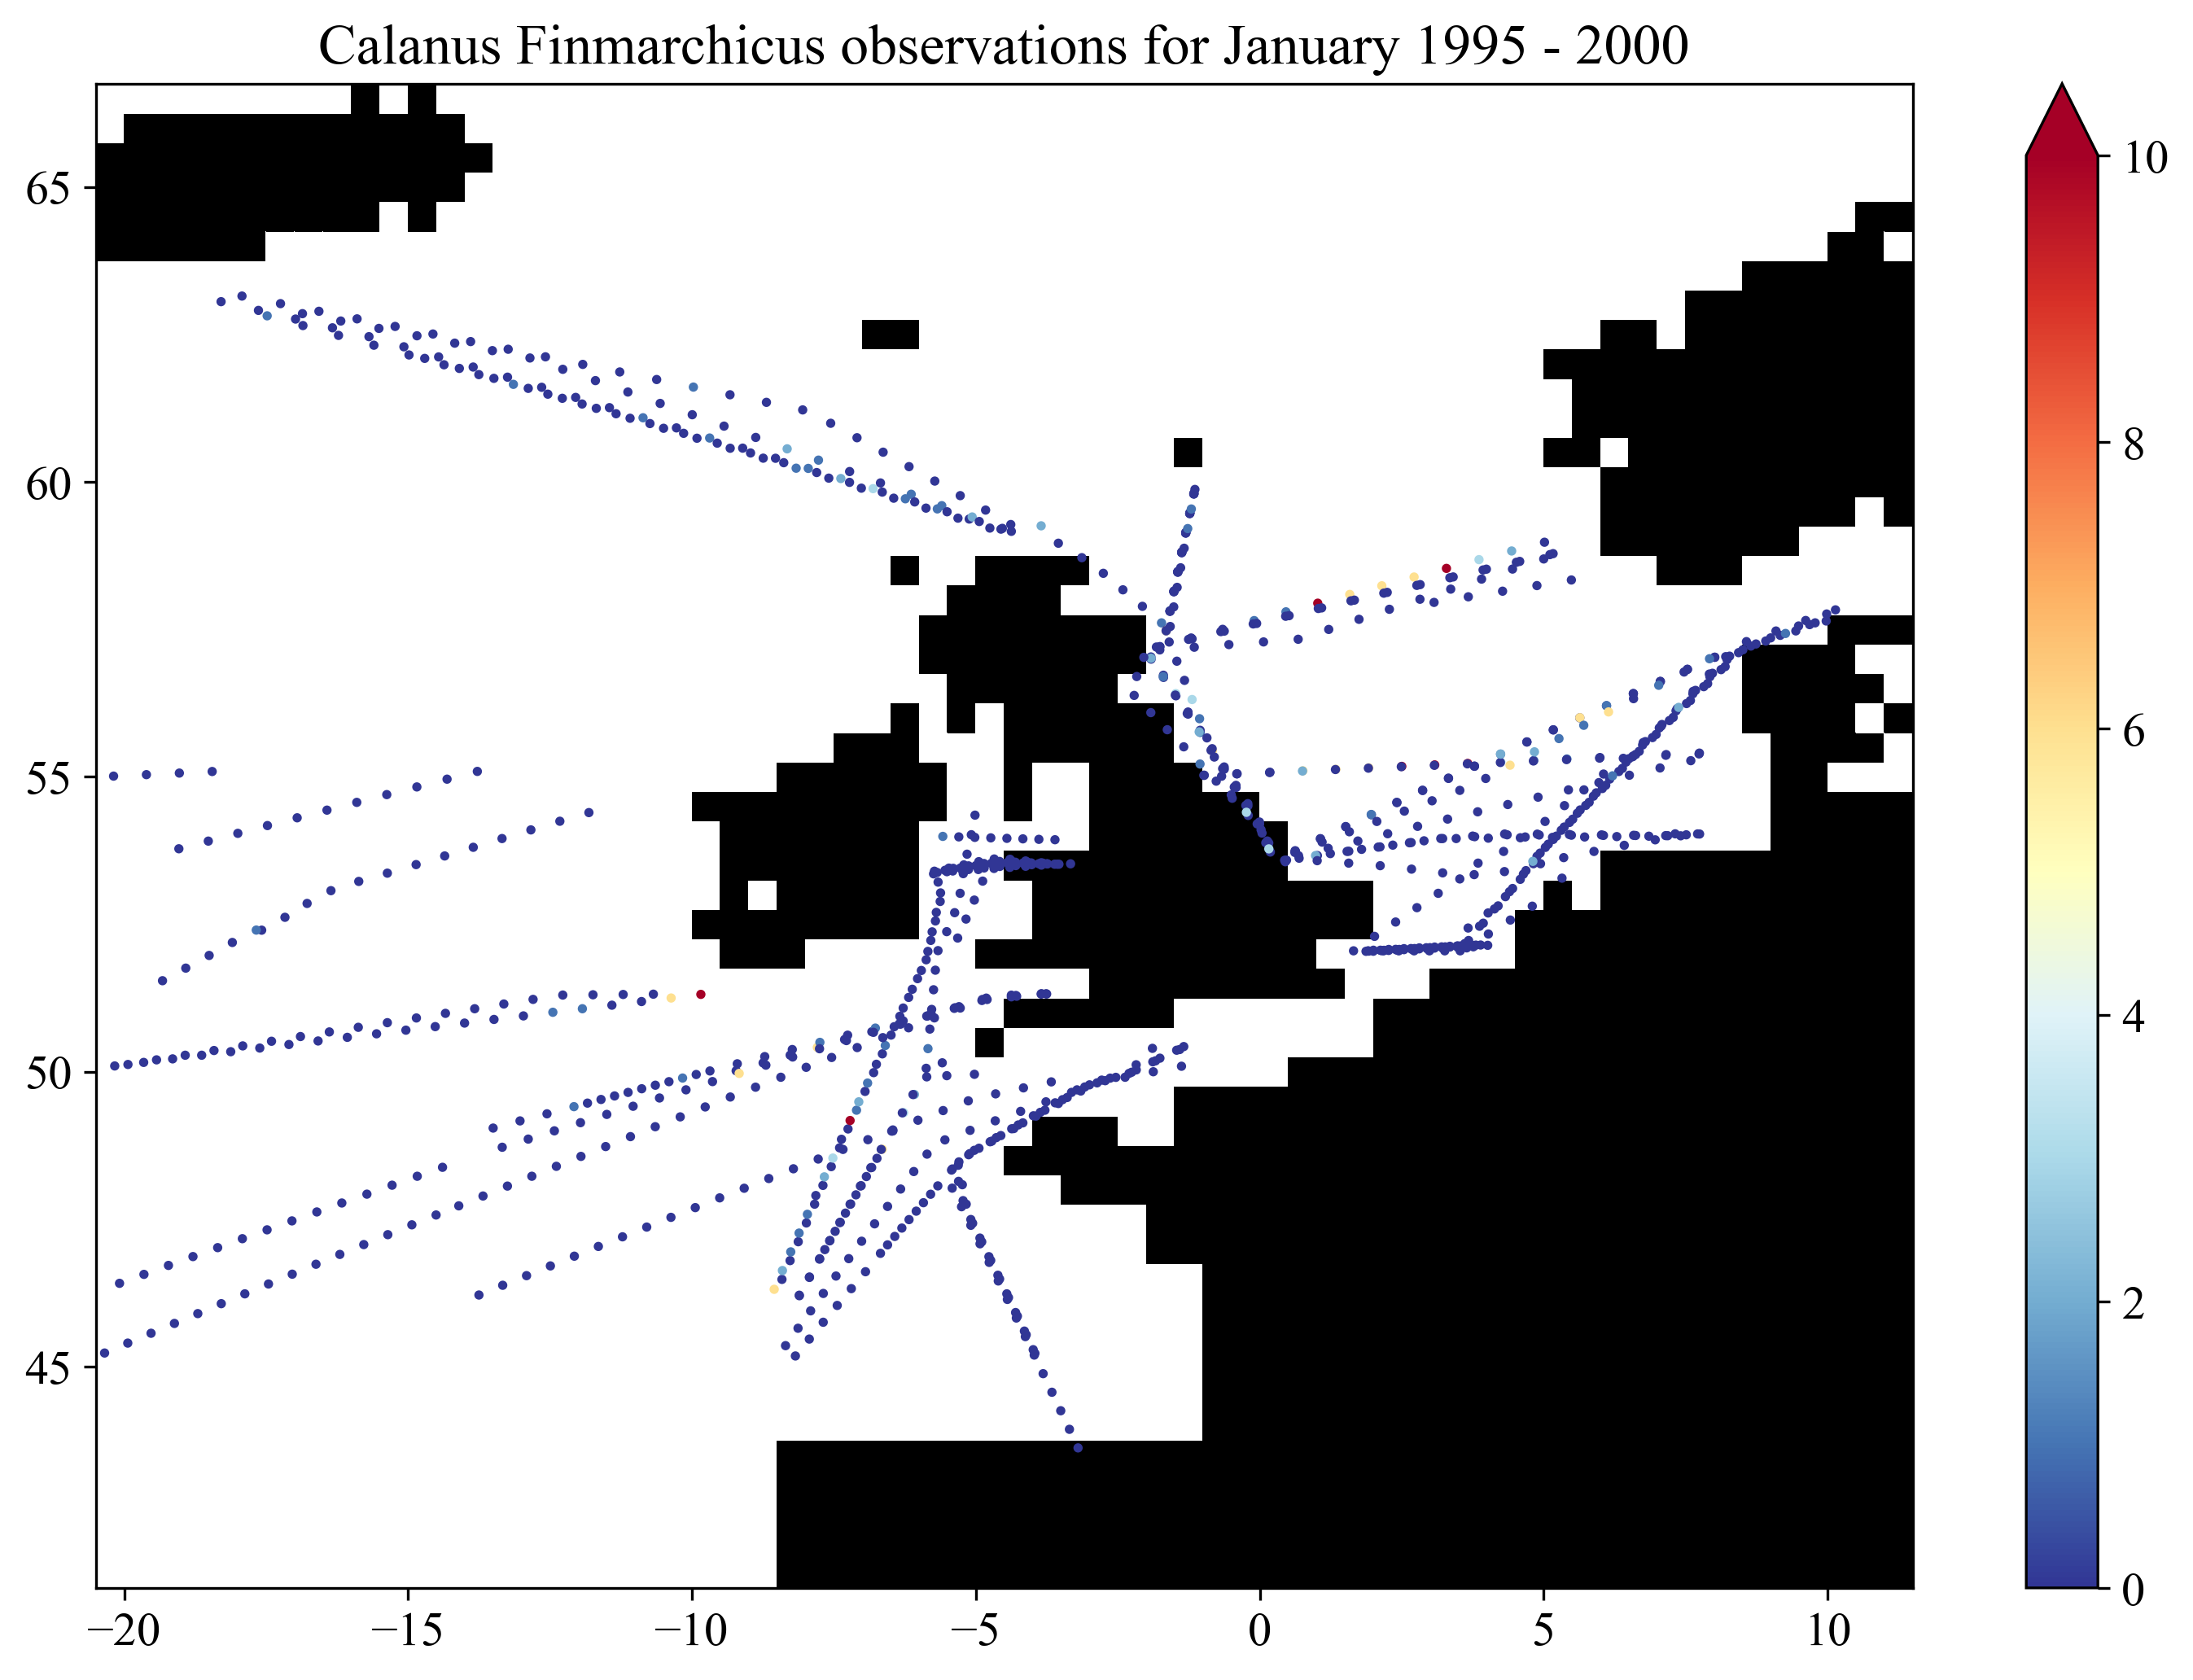

In [16]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
pcm = ax.scatter(lon_calanus, lat_calanus, s=3, c=calanus_finmarchicus_sel, cmap=plt.cm.RdYlBu_r, 
    vmin=0, vmax=10., zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
cb = plt.colorbar(pcm, extend="max")
ax.set_title("Calanus Finmarchicus observations for $(Dates.monthname(imonth)) $(yearmin) - $(yearmax)")
plt.show()

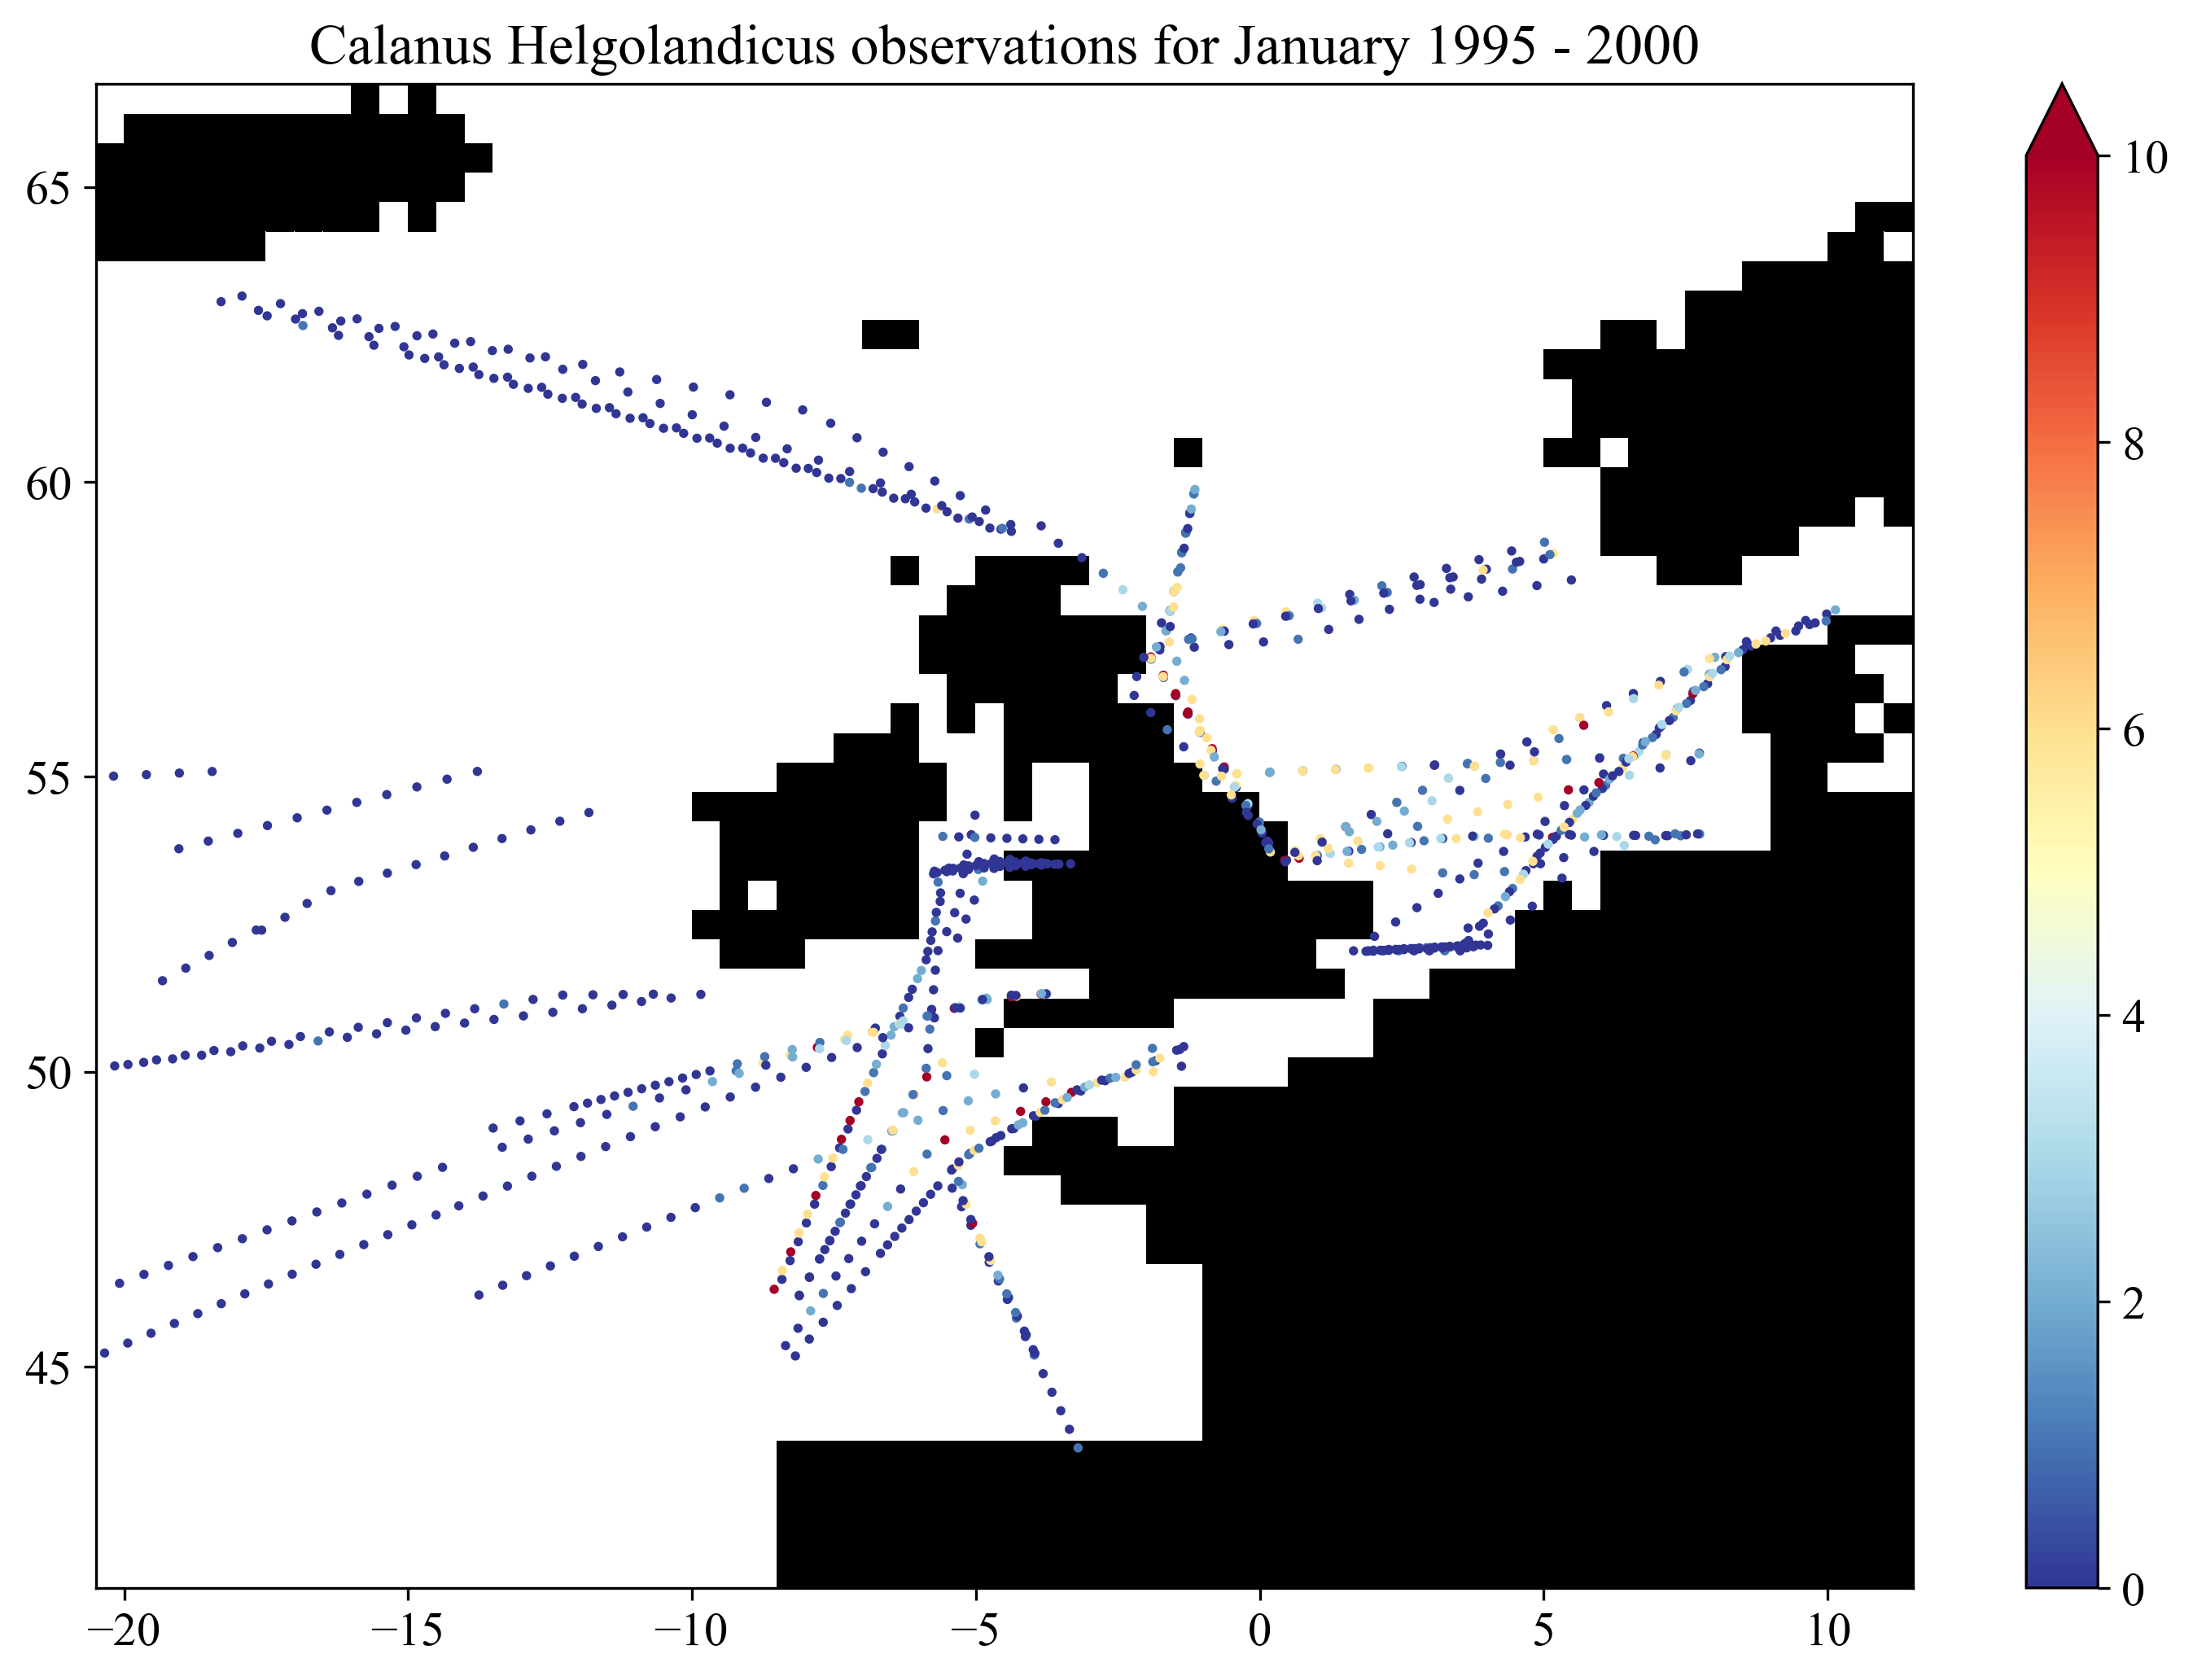

In [17]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
pcm = ax.scatter(lon_calanus, lat_calanus, s=3, c=calanus_helgolandicus_sel, cmap=plt.cm.RdYlBu_r, 
    vmin=0, vmax=10., zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
cb = plt.colorbar(pcm, extend="max")
ax.set_title("Calanus Helgolandicus observations for $(Dates.monthname(imonth)) $(yearmin) - $(yearmax)")
plt.show()

## Univariate analysis
### Parameters

In [18]:
L = 2.5
epsilon2 = 5.

5.0

### Monovariate

In [19]:
@time f_finmarchicus, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lon_calanus, lat_calanus), 
    calanus_finmarchicus_sel .- 0. * mean(calanus_finmarchicus), (L, L), epsilon2);
@time f_helgolandicus, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lon_calanus, lat_calanus), 
    calanus_helgolandicus_sel .- 0. * mean(calanus_helgolandicus_sel), (L, L), epsilon2);

 22.855572 seconds (47.33 M allocations: 2.528 GiB, 4.74% gc time, 99.84% compilation time)
  0.021295 seconds (2.88 k allocations: 30.335 MiB)


In [20]:
@time T_interp, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lonT, latT), 
    dataT .- 1. * mean(dataT), (L, L), epsilon2);

  0.025533 seconds (2.89 k allocations: 33.890 MiB)


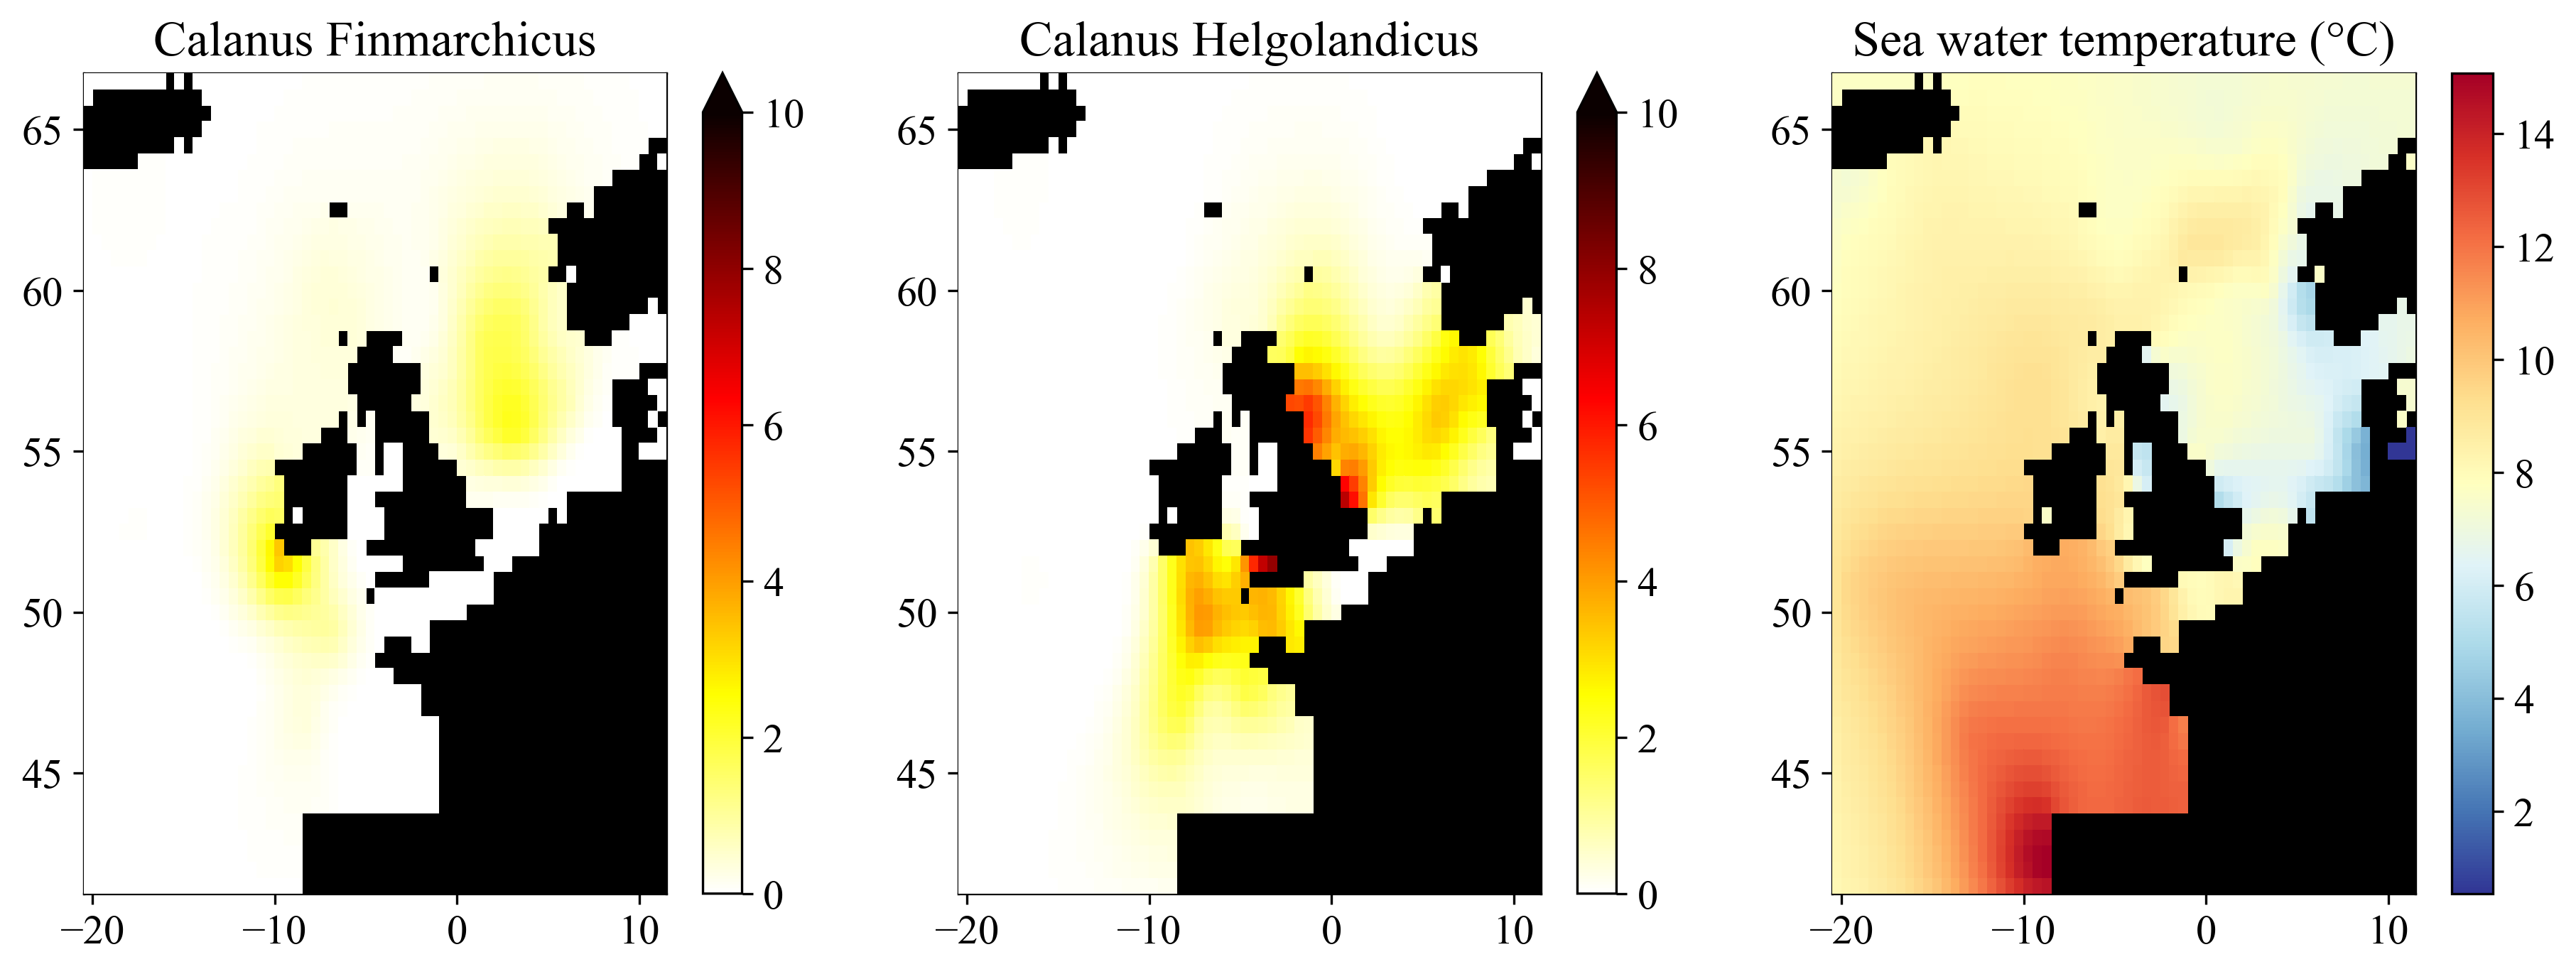

In [21]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
pcm1 = ax.pcolormesh(xi, yi, f_finmarchicus, vmin=0, vmax=10., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Finmarchicus")
cb = plt.colorbar(pcm1, extend="max")

ax = plt.subplot(132)
pcm2 = ax.pcolormesh(xi, yi, f_helgolandicus, vmin=0, vmax=10., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)

ax.set_title("Calanus Helgolandicus")
cb = plt.colorbar(pcm2, extend="max")

ax = plt.subplot(133)
pcm3 = ax.pcolormesh(xi, yi, T_interp .+ mean(dataT), cmap=plt.cm.RdYlBu_r, zorder=3)
ax.pcolormesh(xi, yi, mask, cmap=plt.cm.binary_r, zorder=2)

ax.set_title("Sea water temperature (°C)")
cb = plt.colorbar(pcm3)


plt.show()

## Multivariate analysis
### Data preparation
1. Concatenate all the coordinate and observation vectors
2. Create a new dimension `vvv` with value **1** for plankton data points and **2** for temperature observations.

In [22]:
typeof(lon_calanus), typeof(lonT)

(Vector{Float64}, Vector{Float64})

In [23]:
lonmulti = vcat(lon_calanus, lonT);
latmulti = vcat(lat_calanus, latT);
obsmulti_finmarchicus = vcat(calanus_finmarchicus_sel, dataT .- 1. * mean(dataT))
obsmulti_helgolandicus = vcat(calanus_helgolandicus_sel, dataT.- 1. * mean(dataT))

vvv = vcat(ones(length(lon_calanus)), 2 * ones(length(lonT)));
@info(size(lonmulti), size(vvv));

┌ Info: (6301,)
│   size(vvv) = (6301,)
└ @ Main In[23]:7


### Create metrics

In [24]:
maskmulti, (pm, pn, pv), (xi, yi, vi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid, 1:2);

In [25]:
maskmulti[:,:,1] = mask;
maskmulti[:,:,2] = mask;

### Perform analysis

In [26]:
@time fi1,s = DIVAndrun(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_finmarchicus, 
    (L, L, 0.0), epsilon2);

@time fi2,s = DIVAndrun(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_helgolandicus, 
    (L, L, 0.0), epsilon2);

  8.765383 seconds (19.48 M allocations: 1.052 GiB, 6.07% gc time, 99.26% compilation time)
  0.060986 seconds (4.03 k allocations: 83.324 MiB, 21.83% gc time)


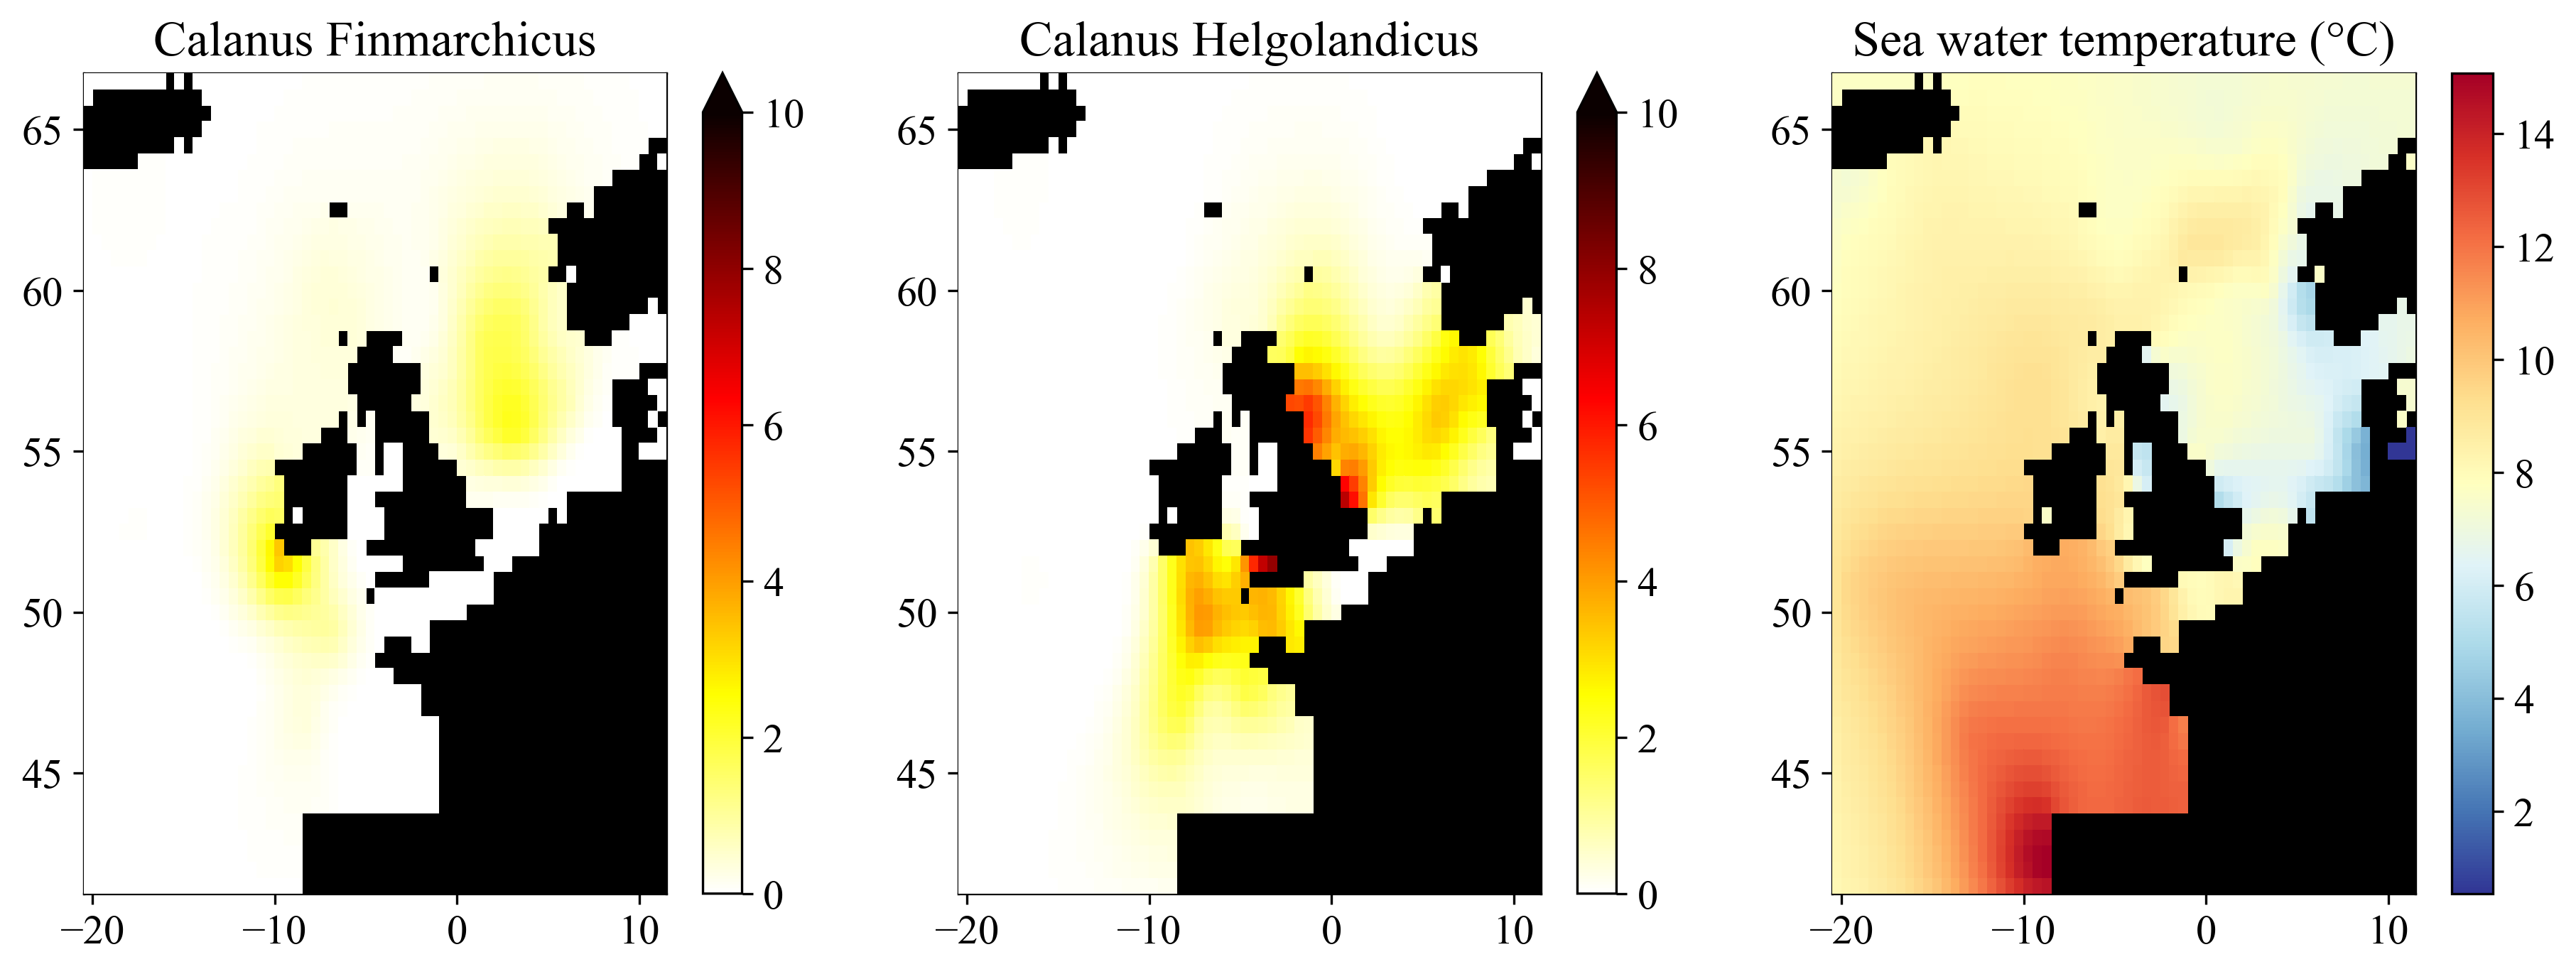

In [27]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
pcm1 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], fi1[:,:,1], vmin=0, vmax=10., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask[:,:,1], cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Finmarchicus")
cb = plt.colorbar(pcm1, extend="max")

ax = plt.subplot(132)
pcm2 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], fi2[:,:,1], vmin=0, vmax=10., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Helgolandicus")
cb = plt.colorbar(pcm2, extend="max")

ax = plt.subplot(133)
pcm3 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], fi1[:,:,2] .+ mean(dataT), cmap=plt.cm.RdYlBu_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Sea water temperature (°C)")
cb = plt.colorbar(pcm3)


plt.show()

### Some tests if we get it right
The 1st _component_ of the multivariate gridded fields should be the same as those obtained with the univariate analysis.         
The 2nd _component_ should be the temperature analysis.

In [28]:
using Test

In [29]:
@test fi1[mask,1] == f_finmarchicus[mask]
@test fi2[mask,1] == f_helgolandicus[mask]
@test fi1[mask,2] == fi2[mask,2]
@test fi1[mask,2] == T_interp[mask]

Test Passed
  Expression: fi1[mask, 2] == T_interp[mask]
   Evaluated: [0.48881993769629123, 0.6424441920622406, 0.7397608427142183, 0.8505761529012396, 0.9765592236853982, 1.119507225261428, 1.2813259565684767, 1.464001000163671, 1.6695567884036748, 1.89999980118516  …  -0.26644510659313997, -0.27023709061477225, -0.2729732644103562, -0.2746548444906527, -0.27533959820066084, -0.27503710414542515, -0.27365041619739733, -0.2709901709524086, -0.2669136451959561, -0.25755380083868745] == [0.48881993769629123, 0.6424441920622406, 0.7397608427142183, 0.8505761529012396, 0.9765592236853982, 1.119507225261428, 1.2813259565684767, 1.464001000163671, 1.6695567884036748, 1.89999980118516  …  -0.26644510659313997, -0.27023709061477225, -0.2729732644103562, -0.2746548444906527, -0.27533959820066084, -0.27503710414542515, -0.27365041619739733, -0.2709901709524086, -0.2669136451959561, -0.25755380083868745]

## Multivariate analysis
### EOF approach

In [30]:
@time fim1, s, eof, eofamplitudes, emap, emapm = 
DIVAnd_multivarEOF(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_finmarchicus, 
    (L, L, 0.0 .*L), epsilon2);

@time fim2, s, eof, eofamplitudes, emap, emapm = 
DIVAnd_multivarEOF(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_helgolandicus, 
    (L, L, 0.0 .*L), epsilon2);

 21.703240 seconds (58.00 M allocations: 3.721 GiB, 7.68% gc time, 96.15% compilation time)
  0.345982 seconds (168.92 k allocations: 620.754 MiB, 6.37% gc time)


#### Plot the gridded fields

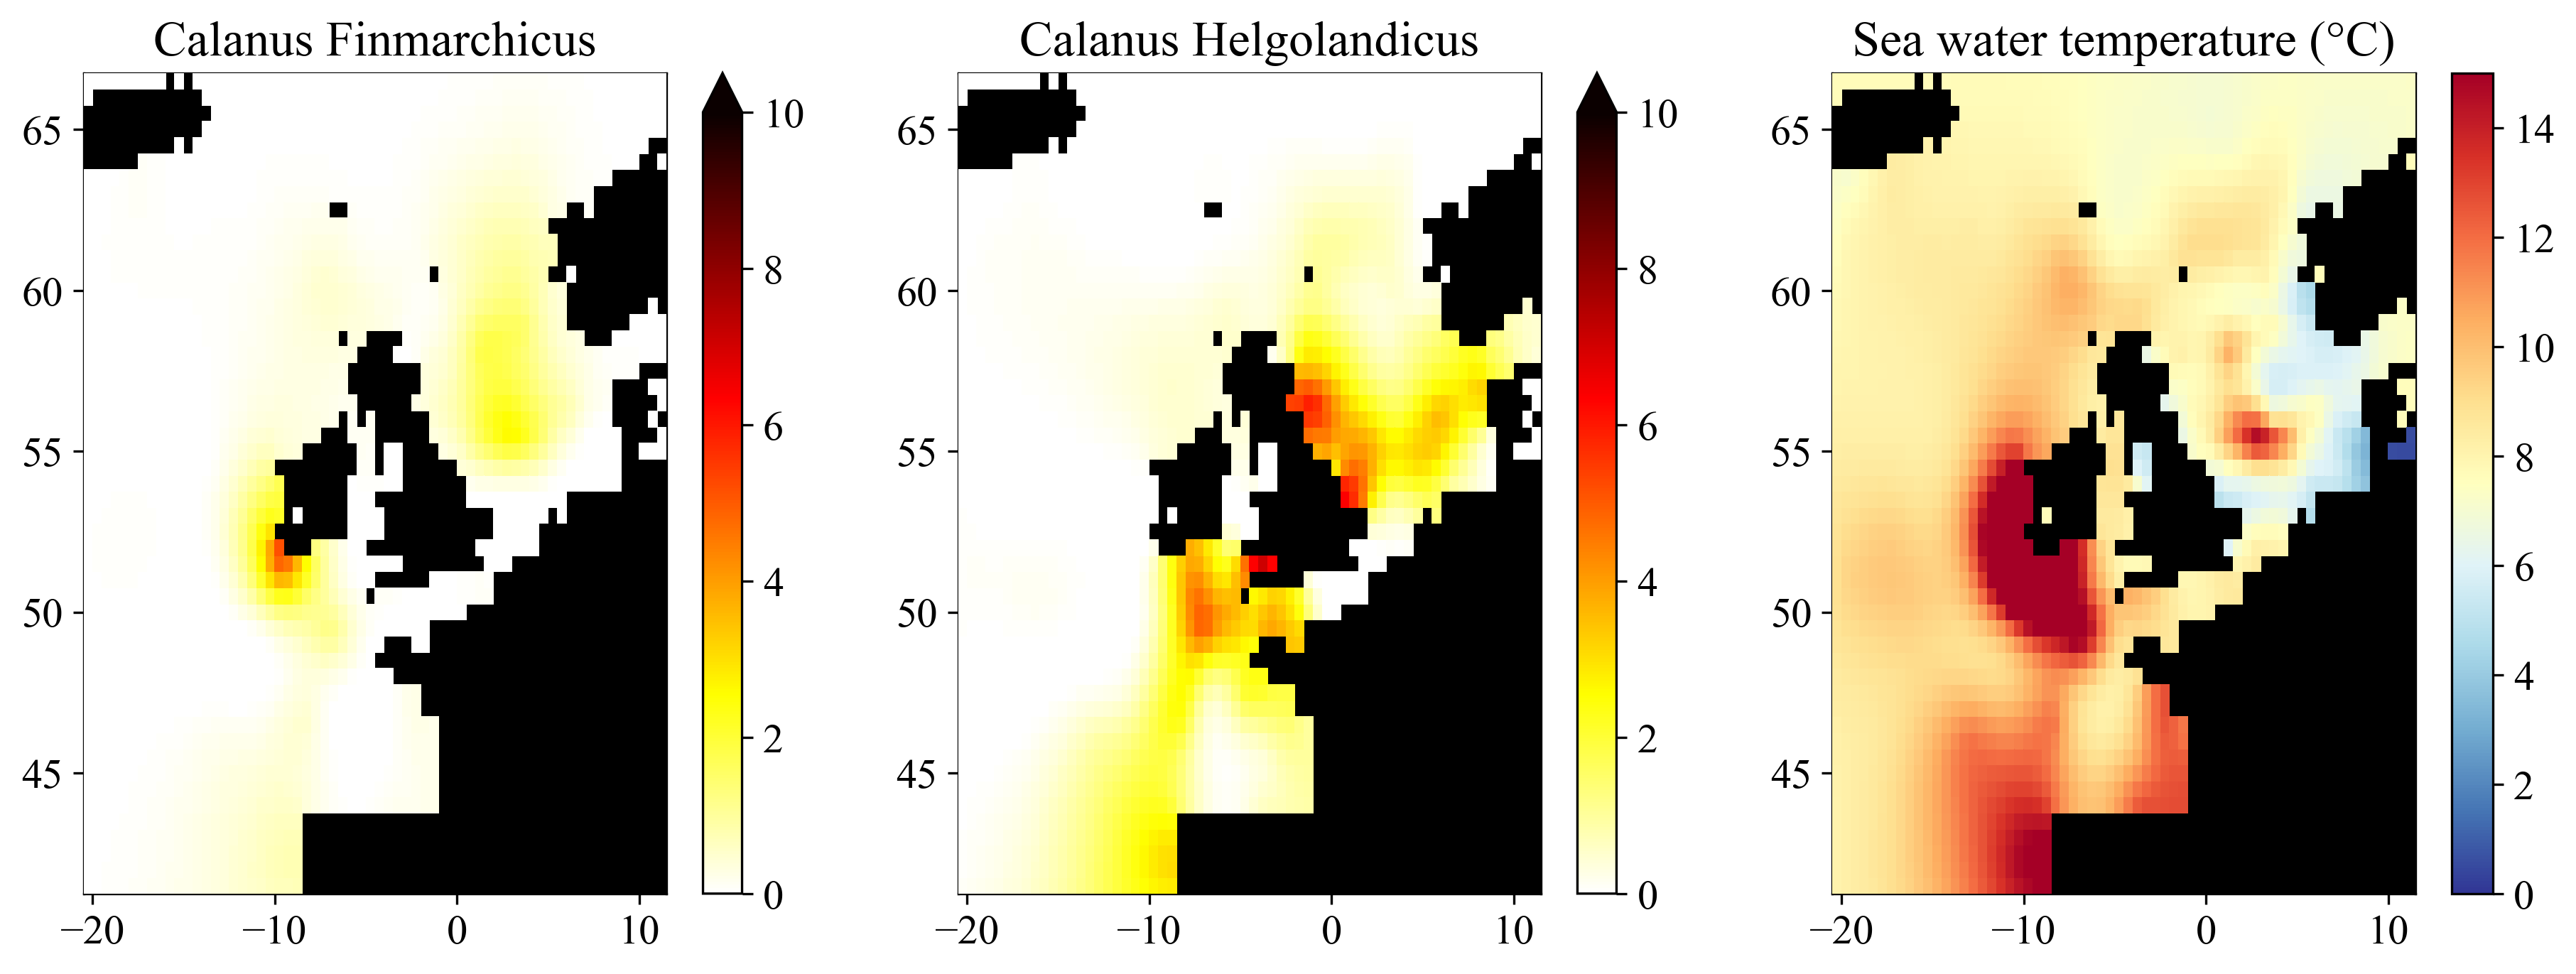

In [31]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
pcm1 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], fim1[:,:,1], vmin=0, vmax=10., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask[:,:,1], cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Finmarchicus")
cb = plt.colorbar(pcm1, extend="max")

ax = plt.subplot(132)
pcm2 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], fim2[:,:,1], vmin=0, vmax=10., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Helgolandicus")
cb = plt.colorbar(pcm2, extend="max")

ax = plt.subplot(133)
pcm3 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], fim1[:,:,2] .+ mean(dataT), cmap=plt.cm.RdYlBu_r, 
    zorder=3, vmin=0., vmax=15.)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Sea water temperature (°C)")
cb = plt.colorbar(pcm3)


plt.show()

### Jacobian approach

In [32]:
len = L * ones(Float64,size(mask));

In [54]:
#@time fim1Jac, s, emap, emapm,pv = 
#DIVAnd_multivarJAC(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_finmarchicus, 
#    (len, len, 0.0 .* len), epsilon2; epsilon2jacobian=(1.0,10.));

@time fim2Jac, s, emap, emapm,pv = DIVAnd_multivarJAC(maskmulti, (pm,pn,pv), (xi,yi,vi), (lonmulti, latmulti, vvv), obsmulti_helgolandicus, 
    (L, L, 0.0), epsilon2);

eps2jac = (1.0, 1.0)


LoadError: BoundsError: attempt to access 3-element Vector{Array{Float64, 3}} at index [1:3, 1:1, 2]

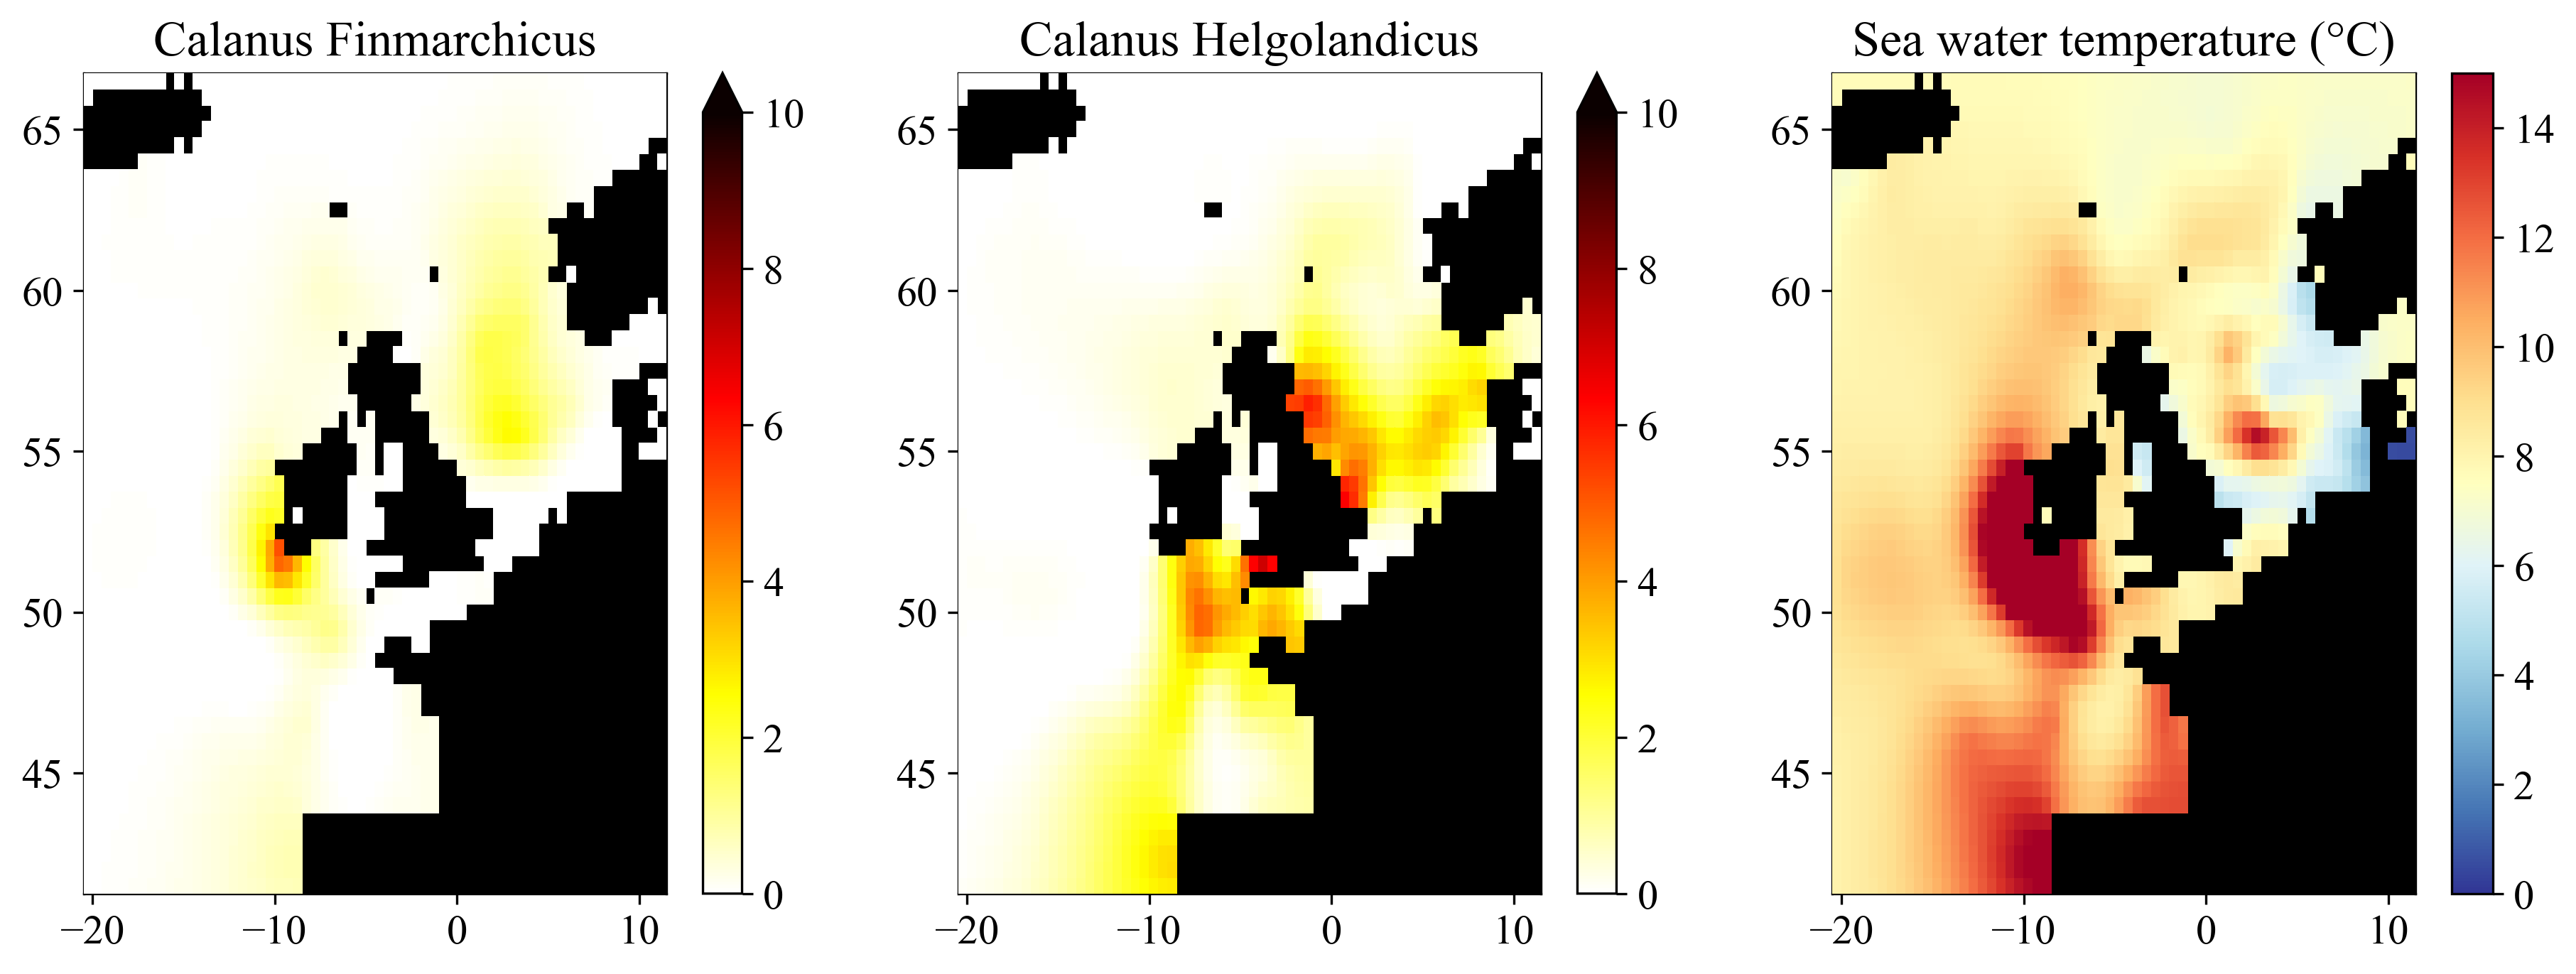

In [35]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
pcm1 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], fim1[:,:,1], vmin=0, vmax=10., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask[:,:,1], cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Finmarchicus")
cb = plt.colorbar(pcm1, extend="max")

ax = plt.subplot(132)
pcm2 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], fim2[:,:,1], vmin=0, vmax=10., cmap=plt.cm.hot_r, zorder=3)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Calanus Helgolandicus")
cb = plt.colorbar(pcm2, extend="max")

ax = plt.subplot(133)
pcm3 = ax.pcolormesh(xi[:,:,1], yi[:,:,1], fim1[:,:,2] .+ mean(dataT), cmap=plt.cm.RdYlBu_r, 
    zorder=3, vmin=0., vmax=15.)
ax.pcolormesh(xi[:,:,1], yi[:,:,1], mask, cmap=plt.cm.binary_r, zorder=2)
ax.set_title("Sea water temperature (°C)")
cb = plt.colorbar(pcm3)


plt.show()